## 1: Current State of the loans

- Summarise currently what percentage of the loans are recovered against the investor funding and the total amount funded. 
- Visualise your results on an appropriate graph. 
- Additionally visualise what percentage of the total amount would be recovered up to 6 months' in the future.

In [1]:
import pandas as pd
import sys
sys.path.append('../')
from modules.data_transform import DataTransform
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('../csv_files/imputed_loan_payments.csv')

In [3]:
transformer = DataTransform()
df = transformer.encode_transform(df)
df = transformer.transform_digit_string(df)
df = transformer.cast_column_dtypes(df)

id --> int32
member_id --> int32
loan_amount --> int32
funded_amount --> float32
funded_amount_inv --> float32
term --> int32
int_rate --> float32
instalment --> float32
grade --> category
sub_grade --> category
employment_length --> int32
home_ownership --> category
annual_inc --> float32
verification_status --> category
issue_date --> date
loan_status --> category
payment_plan --> category
purpose --> category
dti --> float32
delinq_2yrs --> int32
earliest_credit_line --> date
inq_last_6mths --> int32
column not exist
column not exist
open_accounts --> int32
total_accounts --> int32
out_prncp --> float32
out_prncp_inv --> float32
total_payment --> float32
total_payment_inv --> float32
total_rec_prncp --> float32
total_rec_int --> float32
total_rec_late_fee --> float32
recoveries --> float32
collection_recovery_fee --> float32
last_payment_date --> date
last_payment_amount --> float32
column not exist
last_credit_pull_date --> date
collections_12_mths_ex_med --> int32
column not exist

In [4]:
# Q. What percentage of the loans have been recovered at the time the dataset has been created?
# Using total_payment_inv as a percentage of funded_amount_inv
(sum(df['total_payment_inv']) / sum(df['funded_amount_inv'])) * 100

91.01590186425827

In [5]:
# Seems quite a high amount already
# Compare the two columns
df[['total_payment_inv','funded_amount_inv']]

,total_payment_inv,funded_amount_inv
0,2982.510010,8000.0
1,4885.109863,13200.0
2,16824.539062,16000.0
3,15947.469727,15000.0
4,5473.459961,15000.0
...,...,...
54226,2032.290039,1775.0
54227,2787.469971,2350.0
54228,2489.010010,2225.0
54229,232.839996,225.0


In [6]:
# Compare the sum of total_payment_inv and the  sum of funded_amount
print(sum(df['total_payment_inv']))
print(sum(df['funded_amount']))

639326364.1111662
713752375.0


In [7]:
# Perhaps add the interest value to the fundeded_amount_inv
funded_amount_with_interest = df['funded_amount_inv'] + (df['funded_amount_inv'] * (df['int_rate']/100))
sum(funded_amount_with_interest)

801175757.0307274

In [8]:
# Add the the interest value to the principal value left to be paid
total_payment_with_interest = df['total_payment_inv'] + df['total_rec_int']
sum(total_payment_with_interest)

779120709.7122002

In [9]:
# Percentage of total payment made from funded amount with interest
percentage_paid_back_df =(sum(total_payment_with_interest) / sum(funded_amount_with_interest)) * 100

In [10]:
# Perhaps a more accurate way
# 'out_prncp' is the amount outstanding principal to be paid back by the loanee
# 'funded_amount_inv' is the amount committed by the investors which is borrowed by the loanee
# df['funded_amount_inv'] - df['out_prncp'] is the amount paid by the loanee towards the loan (without interest 

principal_paid_back = sum(df['funded_amount_inv'] - df['out_prncp_inv'])
print('amount of principal paid back: ',principal_paid_back)
percentage_principal_paid_back = (principal_paid_back / sum(df['funded_amount_inv']))*100
print('percentage of principal paid back: ',percentage_principal_paid_back)

amount of principal paid back:  553159173.5927553
percentage of principal paid back:  78.74895184250246


In [11]:
# Q. Visualise your results on an appropriate graph
percentage_paid_back_df = pd.DataFrame(data= [percentage_principal_paid_back, 
                                              100-percentage_principal_paid_back],
                                              index = ['percentage paid back','percentage owed'])

In [12]:
percentage_paid_back_df

,0
percentage paid back,78.748952
percentage owed,21.251048


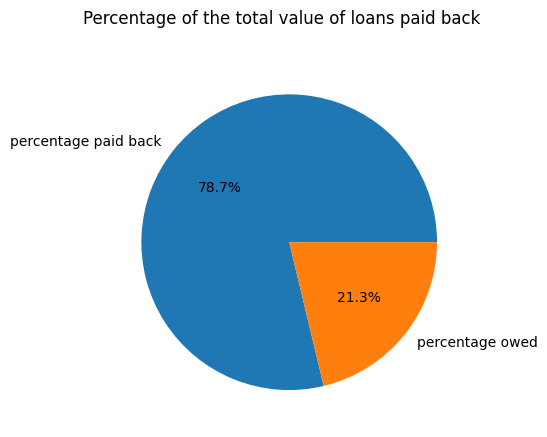

In [13]:
percentage_paid_back_df.plot(kind='pie',title='Percentage of the total value of loans paid back',legend=False,subplots=True, ylabel='',autopct='%1.1f%%')
plt.show()

In [14]:
# Q. Additionally visualise what percentage of the total amount would be recovered up to 6 months' in the future.

# get subset of loans whose status is 'Current'
df_current = df[df['loan_status'] == 'Current']
# columns we need
df_current[['instalment','int_rate','out_prncp_inv']]

,instalment,int_rate,out_prncp_inv
0,248.820007,7.49,5529.700195
1,407.519989,6.99,9102.830078
4,456.540009,6.03,10297.469727
5,83.199997,11.44,1842.680054
8,227.479996,12.99,8480.910156
...,...,...,...
47025,301.320007,21.60,7281.049805
49857,174.380005,11.11,191.250000
51195,399.970001,17.27,3373.709961
52986,86.480003,17.76,798.260010


In [15]:
# remove int_rate from instalment amount
instalment_without_interest = df_current['instalment'] - (df_current['instalment'] * (df_current['int_rate']/100))
instalment_without_interest

0        230.183380
1        379.034332
4        429.010651
5         73.681915
8        197.930344
            ...    
47025    236.234894
49857    155.006393
51195    330.895172
52986     71.121155
53334    722.566406
Length: 19268, dtype: float32

In [16]:
# Calculate the number of months left on the loan term based off the instalments and the amount left to pay on the principal
months_left = df_current['out_prncp_inv'] / instalment_without_interest
months_left

0        24.023022
1        24.015846
4        24.002831
5        25.008579
8        42.847954
           ...    
47025    30.821230
49857     1.233820
51195    10.195706
52986    11.223947
53334    24.046677
Length: 19268, dtype: float32

In [17]:
months_multiplier = months_left.mask(months_left > 6, other=6).mask(months_left <= 6, other=round(months_left))
months_multiplier

0        6.0
1        6.0
4        6.0
5        6.0
8        6.0
        ... 
47025    6.0
49857    1.0
51195    6.0
52986    6.0
53334    6.0
Length: 19268, dtype: float32

In [18]:
amount_to_be_paid_in_6_months = sum(instalment_without_interest * months_multiplier)
print(amount_to_be_paid_in_6_months)

43444868.078495026


In [19]:
principal_paid_back

553159173.5927553

In [20]:
principal_paid_back > amount_to_be_paid_in_6_months

True

In [21]:
# Percentage of total payment in 6 months' time
# Total payments made towards principal in 6 months' time
total_payments_made_in_6_months = principal_paid_back + amount_to_be_paid_in_6_months
total_payments_made_in_6_months

596604041.6712503

In [22]:
percentage_paid_in_6_months = (total_payments_made_in_6_months / sum(df['funded_amount_inv'])) * 100
percentage_paid_in_6_months

84.93385844342968

In [23]:
# Visualise your results on an appropriate graph
percentage_paid_back_6_months_df = pd.DataFrame(data= [percentage_paid_in_6_months, 
                                              100 - percentage_paid_in_6_months],
                                              index = ['percentage to be paid back','percentage owed'])
percentage_paid_back_6_months_df

,0
percentage to be paid back,84.933858
percentage owed,15.066142


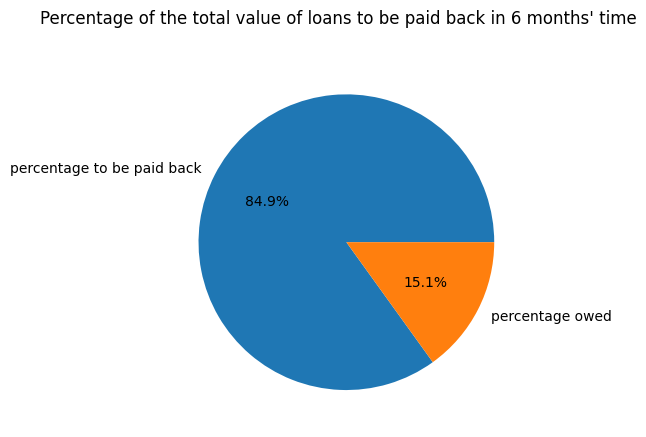

In [24]:
percentage_paid_back_6_months_df.plot(kind='pie',title='Percentage of the total value of loans to be paid back in 6 months\' time',legend=False,subplots=True, ylabel='',autopct='%1.1f%%')
plt.show()